In [134]:
import src.config as c
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import src.db as database
from io import StringIO
import statistics

# Provide the DB connection:
dbc = database.establish(file=f"{c.DATA_PATH}/reports-offline.sqlite3")

plt.style.use("fast");

## RQ 1.1: Accuracy of Proof of Concepts

In [215]:
sda_df = pd.read_sql_query("SELECT * from small_dim_array", dbc)
sdvl_df = pd.read_sql_query("SELECT * from smalldim_varlength", dbc)
lrlr_df = pd.read_sql_query("SELECT * from large_random_longrun", dbc)

correct_line = [*range(5, 7), "F"]

# Gather correct answers
sda_scores = {}

for i in sda_df.index:
    c_data = 0
    c_line = 0
    c_explanation = 0

    require_data = ["F", "1"]
    if all(e in str(sda_df.loc[i].data) for e in require_data):
        c_data = 1

    line_entry = sda_df.loc[i].line
    try:
        if int(line_entry) in correct_line:
            c_line = 1
    except ValueError:
        try:
            for le in line_entry.split("/"):
                if le in correct_line:
                    c_line = 1
        except Exception:
            pass

    if any(e in str(sda_df.loc[i].explanation) for e in require_data):
        c_explanation = 1

    sda_scores[str(sda_df.loc[i].uid)] = {
        "line": c_line,
        "data": c_data,
        "explanation": c_explanation,
        "total": c_line + c_data + c_explanation,
    }

# Convert scores to dataframe
sda_scores_df = pd.read_json(StringIO(json.dumps(sda_scores)), orient="index")

# Gather correct answers
sdvl_scores = {}

for i in sdvl_df.index:
    c_data = 0
    c_line = 0
    c_explanation = 0

    require_data = ["/etc/shadow"]
    correct_line = [int(sdvl_df.loc[i].query_interest)]

    if all(e in str(sdvl_df.loc[i].data) for e in require_data):
        c_data = 1

    line_entry = sdvl_df.loc[i].line
    try:
        if int(line_entry) in correct_line:
            c_line = 1
    except ValueError:
        try:
            for le in line_entry.split("/"):
                if le in correct_line:
                    c_line = 1
        except Exception:
            pass

    explanation_data = [*require_data, "directory", "password", "vulnerability"]
    if any(e in str(sdvl_df.loc[i].explanation) for e in require_data):
        c_explanation = 1

    sdvl_scores[str(sdvl_df.loc[i].uid)] = {
        "line": c_line,
        "data": c_data,
        "explanation": c_explanation,
        "total": c_line + c_data + c_explanation,
    }

# Convert scores to dataframe
sdvl_scores_df = pd.read_json(StringIO(json.dumps(sdvl_scores)), orient="index")

lrlr_scores = {}
for i in lrlr_df.index:
    c_data = 0
    c_line = 0
    c_explanation = 0

    require_data = ["/etc/shadow", "93.164.60.142"]
    correct_line = [int(lrlr_df.loc[i].query_interest)]

    if all(e in str(lrlr_df.loc[i].data) for e in require_data):
        c_data = 1

    line_entry = lrlr_df.loc[i].line
    try:
        if int(line_entry) in correct_line:
            c_line = 1
    except ValueError:
        try:
            for le in line_entry.split("/"):
                if le in correct_line:
                    c_line = 1
        except Exception:
            pass

    explanation_data = [*require_data, "directory", "password", "vulnerability"]
    if any(e in str(lrlr_df.loc[i].explanation) for e in require_data):
        c_explanation = 1

    lrlr_scores[str(lrlr_df.loc[i].uid)] = {
        "line": c_line,
        "data": c_data,
        "explanation": c_explanation,
        "total": c_line + c_data + c_explanation,
    }

# Convert scores to dataframe
lrlr_scores_df = pd.read_json(StringIO(json.dumps(lrlr_scores)), orient="index")

     line  data  explanation  total
0       0     0            0      0
1       0     0            0      0
2       0     0            1      1
3       0     0            0      0
4       0     0            1      1
..    ...   ...          ...    ...
301     0     1            1      2
302     0     1            1      2
303     0     1            1      2
304     0     1            1      2
305     0     1            1      2

[306 rows x 4 columns]


Text(0.5, 1.0, 'Percentage of quries with successful anomaly detection')

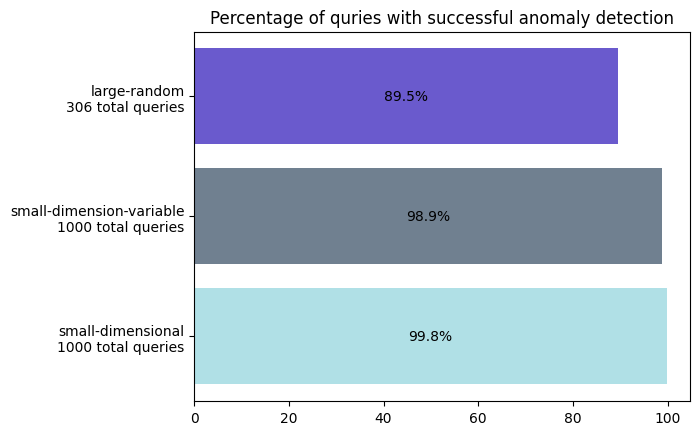

In [220]:
evaluations = [
    f"small-dimensional\n{len(sda_scores_df.index)} total queries",
    f"small-dimension-variable\n{len(sdvl_scores_df.index)} total queries",
    f"large-random\n{len(lrlr_scores_df.index)} total queries",
]
results = [
    round(
        (
            sum([1 if i > 0 else 0 for i in sda_scores_df.total])
            / len(sda_scores_df.index)
        )
        * 100,
        1,
    ),
    round(
        (
            sum([1 if i > 0 else 0 for i in sdvl_scores_df.total])
            / len(sdvl_scores_df.index)
        )
        * 100,
        1,
    ),
    round(
        (
            sum([1 if i > 0 else 0 for i in lrlr_scores_df.total])
            / len(lrlr_scores_df.index)
        )
        * 100,
        1,
    ),
]

fig, ax = plt.subplots()
bars = ax.barh(
    evaluations,
    results,
    align="center",
    color=["powderblue", "slategray", "slateblue"],
)
ax.bar_label(bars, fmt="{}%", label_type="center")

plt.title("Percentage of quries with successful anomaly detection")

## RQ 2.1: Data, Line, Explanation

### Sliding Context Window

In [105]:
# Sliding Context Window
df = pd.read_sql_query("SELECT * from sliding_context_window", dbc)

# Let's set the score card
scores = {}

query_interest = df["query_interest"].to_list()
for i, x in enumerate(query_interest):
    c_data = 0
    c_line = 0
    c_explanation = 0

    correct_line = json.loads(x)[0]
    if str(correct_line) in str(df.loc[i].line):
        c_line = 1

    correct_data = json.loads(x)[1]
    if str(correct_data) in str(df.loc[i].data):
        c_data = 1

    if str(correct_line) in str(df.loc[i].explanation) or str(correct_data) in str(
        df.loc[i].explanation
    ):
        c_explanation = 1

    # Custom marker for this eval
    if "ffffffffffffffff" in str(df.loc[i].explanation):
        c_explanation = 1

    scores[str(df.loc[i].uid)] = {
        "line": c_line,
        "data": c_data,
        "explanation": c_explanation,
    }

# Convert scores to dataframe
scores_df = pd.read_json(StringIO(json.dumps(scores)), orient="index")

In [ ]:
scores_df[scores_df.line == 1].line.to_list()
scores_df[scores_df.line == 1].index.to_list()
fig, ax = plt.subplots()

ax.eventplot(
    positions=[
        scores_df[scores_df.line == 1].index.to_list(),
        scores_df[scores_df.line == 0].index.to_list(),
        scores_df[scores_df.data == 1].index.to_list(),
        scores_df[scores_df.data == 0].index.to_list(),
        scores_df[scores_df.explanation == 1].index.to_list(),
        scores_df[scores_df.explanation == 0].index.to_list(),
    ],
    data=[
        scores_df[scores_df.line == 1].line.to_list(),
        scores_df[scores_df.line == 0].line.to_list(),
        scores_df[scores_df.data == 1].data.to_list(),
        scores_df[scores_df.data == 0].data.to_list(),
        scores_df[scores_df.explanation == 1].explanation.to_list(),
        scores_df[scores_df.explanation == 0].explanation.to_list(),
    ],
    colors=[
        "lightgreen",
        "lightcoral",
        "lightgreen",
        "lightcoral",
        "lightgreen",
        "lightcoral",
    ],
    linelengths=1,
    linewidths=4,
    lineoffsets=[1, 1, 3, 3, 5, 5],
)

# Let's add query count too
ax_top = ax.twiny()
ax_top.set_xlabel("Query Count")
ax_top.set_xticks(range(0, 140, 10))
# ax_top.set_xticklabels(range(0,127,10))

ax.set_yticks([1, 3, 5], ["line", "data", "explanation"])
ax.set_xlabel("Context Window Size")
plt.show()

In [ ]:
# Average response time
# *10 because I messed up the math in my original calculation
# (statistics.fmean(df["query_duration_microseconds"].to_list()) * 10) / 1_000_000
print(
    f"AVG RESPONSE TIME: {round((statistics.fmean(df.query_duration_microseconds.to_list()) * 10 / 1_000_000),1)} seconds"
)
[
    print(
        f"CORRECT {x}: {round((len(scores_df[scores_df[x]==1])/len(scores_df) * 100),1)}%"
    )
    for x in scores_df
]


### Multi Source

In [130]:
df = pd.read_sql_query("SELECT * from multi_source", dbc)
explanation_scores = pd.read_csv(f"{c.DATA_PATH}/multi-source-explanation.csv")
correct_line = [e for e in [*range(1, 17), 139]]
# Let's set the score card
scores = {}

uids = df["uid"].to_list()

for i in uids:
    c_data = 0
    c_line = 0
    c_explanation = 0

    # Correct as long as one of the lines appears
    line_entry = df.loc[i].line
    try:
        if int(line_entry) in correct_line:
            c_line = 1
    except ValueError:
        try:
            for le in line_entry.split("/"):
                if le in correct_line:
                    c_line = 1
        except Exception:
            pass

    # We all of require the following:
    require_data = ["[IPTABLES INPUT] REJECT", "93.164.60.142", "/etc/shadow"]
    if any(e in str(df.loc[i].data) for e in require_data):
        c_data = 1

    # Explanation scores are manually noted for this.
    c_explanation = int(explanation_scores.loc[i].score)

    scores[str(i)] = {
        "line": c_line,
        "data": c_data,
        "explanation": c_explanation,
    }

# Convert scores to dataframe
scores_df = pd.read_json(StringIO(json.dumps(scores)), orient="index")

In [ ]:
scores_df[scores_df.line == 1].line.to_list()
scores_df[scores_df.line == 1].index.to_list()
fig, ax = plt.subplots()

ax.eventplot(
    positions=[
        scores_df[scores_df.line == 1].index.to_list(),
        scores_df[scores_df.line == 0].index.to_list(),
        scores_df[scores_df.data == 1].index.to_list(),
        scores_df[scores_df.data == 0].index.to_list(),
        scores_df[scores_df.explanation == 1].index.to_list(),
        scores_df[scores_df.explanation == 0].index.to_list(),
    ],
    data=[
        scores_df[scores_df.line == 1].line.to_list(),
        scores_df[scores_df.line == 0].line.to_list(),
        scores_df[scores_df.data == 1].data.to_list(),
        scores_df[scores_df.data == 0].data.to_list(),
        scores_df[scores_df.explanation == 1].explanation.to_list(),
        scores_df[scores_df.explanation == 0].explanation.to_list(),
    ],
    colors=[
        "lightgreen",
        "lightcoral",
        "lightgreen",
        "lightcoral",
        "lightgreen",
        "lightcoral",
    ],
    linelengths=1,
    linewidths=4,
    lineoffsets=[1, 1, 3, 3, 5, 5],
)

ax.set_yticks([1, 3, 5], ["line", "data", "explanation"])
ax.set_xlabel("Query Count")
plt.show()

In [ ]:
print(f"TOTAL: {len(scores_df)}")
# Average response time
# *10 because I messed up the math in my original calculation
# (statistics.fmean(df["query_duration_microseconds"].to_list()) * 10) / 1_000_000
print(
    f"AVG RESPONSE TIME: {round((statistics.fmean(df.query_duration_microseconds.to_list()) * 10 / 1_000_000),1)} seconds"
)
[
    print(
        f"CORRECT {x}: {round((len(scores_df[scores_df[x]==1])/len(scores_df) * 100),1)}%"
    )
    for x in scores_df
]
overall_correct = 0
for i in df["uid"].to_list():
    overall_correct += (
        1
        if (
            scores_df.loc[i].line + scores_df.loc[i].data + scores_df.loc[i].explanation
        )
        > 0
        else 0
    )
print(f"OVERALL CORRECT: {round((overall_correct/len(scores_df))*100,1)}")

In [ ]:
# print(df.loc[2].line, scores_df.loc[2].line)
correct_line = [e for e in [*range(1, 17), 139]]
# print(correct_line)
for i in uids:
    c_line = 0
    line_entry = df.loc[i].line
    try:
        if int(line_entry) in correct_line:
            c_line = 1
    except ValueError:
        try:
            for le in line_entry.split("/"):
                if le in correct_line:
                    c_line = 1
        except Exception:
            pass

    print(f"{i}: {c_line}")
    # if any(e in str(df.loc[i].line) for e in correct_line):

## RQ 2.2: Query Size Success


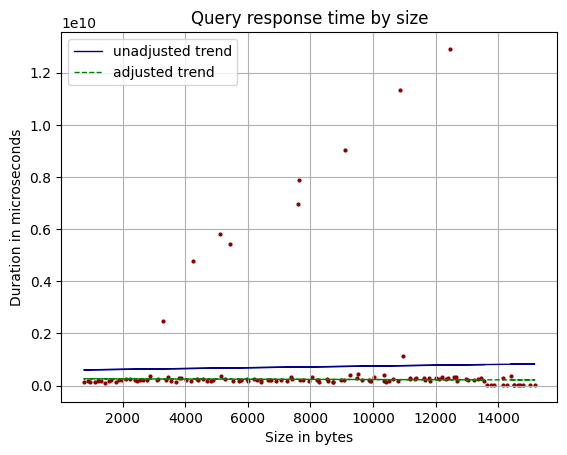

In [251]:
df = pd.read_sql_query(
    "SELECT query_duration_microseconds, query_size_bytes from query_growth", dbc
)

# Correct for the source duration error
df.query_duration_microseconds = df['query_duration_microseconds'].apply(lambda x: x * 10)

plt.scatter(
    x=df["query_size_bytes"], y=df["query_duration_microseconds"], c="DarkRed", s=4
)
plt.title("Query response time by size")
plt.xlabel("Size in bytes")
plt.ylabel("Duration in microseconds")

# Add trend
trendline = np.poly1d(
    np.polyfit(df["query_size_bytes"], df["query_duration_microseconds"], 1)
)
plt.plot(
    df["query_size_bytes"],
    trendline(df["query_size_bytes"]),
    linewidth=1,
    color="DarkBlue",
    linestyle="-",
    label="unadjusted trend",
)

# Adjusted trendline
# This will demonstrate a 10-second timeout
adj_duration = df["query_duration_microseconds"].clip(lower=0, upper=600_000_000)
adj_trendline = np.poly1d(np.polyfit(df["query_size_bytes"], adj_duration, 1))

plt.plot(
    df["query_size_bytes"],
    adj_trendline(df["query_size_bytes"]),
    linewidth=1,
    color="Green",
    linestyle="--",
    label="adjusted trend",
)

# Show the grid
plt.grid(True)

# Show legend
plt.legend()
plt.show()

In [256]:
print(len(df))
adj_list = []
for i in df.query_duration_microseconds:
    if i < 600_000_000:
        adj_list.append(i)

print(len(df) - len(adj_list))
def most_common(lst):
    return max(set(lst), key=lst.count)
print(round((most_common(df.query_duration_microseconds.to_list())/100_000)/60,1))
print(round((statistics.mean(df.query_duration_microseconds.to_list())/100_000)/60,1))
print(round((statistics.mean(adj_list)/100_000)/60,1))

129
10
4.1
119.1
34.3
